In [1]:
import os 
import sys
from pathlib import Path
from typing import Dict, List, Tuple

import pandas as pd
import numpy as np
import torch
from speechbrain.utils.metric_stats import EER
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
from copy import deepcopy

sys.path.append('../.')
from src.modules.metrics.metrics import VerificationMetrics

INFO:speechbrain.utils.quirks:Applied quirks (see `speechbrain.utils.quirks`): [allow_tf32, disable_jit_profiling]
INFO:speechbrain.utils.quirks:Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []
2025-02-12 15:10:12.840612: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Scores Manipulation

In [2]:
model_exp = Path('/home.local/aloradi/logs/train/runs/2025-02-02_22-12-58')
anon_model = 'B3'
eval_test = True

scores_csv_file = 'test_scores.csv' if eval_test else'valid_scores.csv'
data_df_file = 'test.csv' if eval_test else'dev.csv'

tmp = list(model_exp.rglob(f'*/{scores_csv_file}'))
assert len(tmp) == 1, f'Expected one file called test_scores.csv, found: {len(tmp)}'
scores_path = tmp[0]

df = pd.read_csv(f'{scores_path}')
df_test = pd.read_csv(f'{str(model_exp / f"vpc2025_artifacts/{data_df_file}")}', sep="|")

df['rel_filepath'] = df['audio_path'].str.extract(fr'({anon_model}.*)')
df = df.merge(df_test[['speaker_id', 'rel_filepath', 'gender', 'recording_duration', 'text']], on='rel_filepath', how='left')

### eval anon model ###
df = df[df['model'] == anon_model]

## Plotting Utils

In [3]:
def create_radar_plot(eer_results_speaker,
                      output_path,
                      title="Speaker-specific EER",
                      description="Equal Error Rate (EER) across different speakers"):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_axes([0.1, 0.1, 0.6, 0.8], polar=True)
    
    labels = list(eer_results_speaker.keys())
    values = list(eer_results_speaker.values())
    labels = list(eer_results_speaker.keys())
    values = list(eer_results_speaker.values())
    num_vars = len(labels)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    
    values += values[:1]
    angles += angles[:1]
    
    ax.plot(angles, values, color='#FF6B6B', linewidth=2, marker='o', 
           markersize=8, label='EER Values')
    
    ax.grid(color='gray', alpha=0.2, linestyle='--', linewidth=1)
    ax.set_ylim(0, max(values) * 1.2)
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=10, fontweight='bold')
    
    for i in range(num_vars):
        angle_rad = angles[i]
        angle_deg = angle_rad * 180 / np.pi
        
        if angle_deg > 90 and angle_deg < 270:
            rotation = angle_deg + 180
        else:
            rotation = angle_deg
            
        ax.text(angle_rad, values[i] + max(values) * 0.1,
                f'{values[i]:.2f}',
                ha='center', va='center',
                rotation=rotation,
                fontsize=9,
                bbox=dict(facecolor='white', 
                         edgecolor='none',
                         alpha=0.8,
                         pad=2))
    
    plt.title(title, pad=20, fontsize=14, fontweight='bold')
    ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))

    plt.savefig(output_path, 
                dpi=300, 
                bbox_inches='tight',
                pad_inches=0.5,
                format='png',
                transparent=True)
    plt.close()
    
    return fig, ax

## Compute gender/speaker metrics

In [12]:
def compute_gender_metrics(df: pd.DataFrame) -> Tuple[Dict, Dict, Dict]:
    """
    Compute verification metrics for each gender.
    
    Args:
        df: DataFrame with columns ['gender', score', 'label']
    
    Returns:
        gender_metrics: Dict of metrics per gender
        gender_curves: Dict of curve data per gender
        gender_eer: Dict of EER values per gender
    """
    gender_metrics = {}
    gender_curves = {}
    gender_eer = {}
    metric = VerificationMetrics()
    
    for gender in df['gender'].unique():
        metric.reset()
        gender_data = df[df['gender'] == gender]
        
        # Compute metrics
        metric.update(
            torch.from_numpy(gender_data['score'].values),
            torch.from_numpy(gender_data['label'].values)
        )
        metrics = metric.compute()
        
        # Store results
        gender_metrics[gender] = metrics
        gender_curves[gender] = {
            k: v.detach().cpu().numpy() 
            for k, v in metric._curve_data.items()
        }
        gender_eer[gender] = metrics['eer']
        
    return gender_metrics, gender_curves, gender_eer


def plot_gender_det_curves(gender_curves: Dict, gender_metrics: Dict, eps: float = 1e-8) -> plt.Figure:
    """
    Plot DET curves for multiple speakers.
    
    Args:
        gender_curves: Dict of curve data per speaker
        gender_metrics: Dict of metrics per speaker
        eps: Small value for numerical stability
    
    Returns:
        Matplotlib figure
    """
    plt.style.use('seaborn-v0_8-paper')
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Get sorted genders for consistent ordering
    genders = sorted(gender_curves.keys())
    
    # Define fixed colors for consistency
    GENDER_COLORS = {'female': '#FF69B4','male': '#4169E1'}
    
    # Plot each speaker's curve
    mean_eer = []
    for gender in genders:
        curves = gender_curves[gender]
        metrics = gender_metrics[gender]
        
        far = np.maximum(curves['far'], eps)
        frr = np.maximum(curves['frr'], eps)
        eer = metrics['eer']
        mean_eer.append(eer)
        
        ax.plot(far, frr, '-', color=GENDER_COLORS.get(gender, 'gray'), alpha=0.5, linewidth=1, label=f'{gender} (EER: {eer:.3f})')
    
    # Plot mean EER point for visual clarity
    mean_eer_value = np.mean(mean_eer)
    ax.plot(mean_eer_value, mean_eer_value, 'ko', markersize=8, label=f'Mean EER: {mean_eer_value:.3f}')
    
    # Plot diagonal
    ax.plot([eps, 1], [eps, 1], 'k--', alpha=0.3, linewidth=1)
    
    # Customize plot
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('False Acceptance Rate (FAR)')
    ax.set_ylabel('False Rejection Rate (FRR)')
    ax.set_title('Detection Error Tradeoff (DET) Curves by Gender')
    ax.grid(True, which='both', linestyle='--', alpha=0.3)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True, fancybox=False, edgecolor='black')
    
    fig.tight_layout()
    return fig


def compute_speaker_metrics(df: pd.DataFrame) -> Tuple[Dict, Dict, Dict]:
    """
    Compute verification metrics for each speaker.
    
    Args:
        df: DataFrame with columns ['enrollment_id', 'speaker_id', 'score', 'label']
    
    Returns:
        speaker_metrics: Dict of metrics per speaker
        speaker_curves: Dict of curve data per speaker
        speaker_eer: Dict of EER values per speaker ID
    """
    speaker_metrics = {}
    speaker_curves = {}
    speaker_eer = {}
    metric = VerificationMetrics()
    
    for speaker in df['enrollment_id'].unique():
        metric.reset()
        speaker_data = df[df['speaker_id'] == speaker]
        
        # Compute metrics
        metric.update(
            torch.from_numpy(speaker_data['score'].values),
            torch.from_numpy(speaker_data['label'].values)
        )
        metrics = metric.compute()
        
        # Store results
        speaker_metrics[speaker] = metrics
        speaker_curves[speaker] = {
            k: v.detach().cpu().numpy() 
            for k, v in metric._curve_data.items()
        }
        speaker_eer[speaker.split('_')[-1]] = metrics['eer']
        
    return speaker_metrics, speaker_curves, speaker_eer


def plot_speaker_det_curves(speaker_curves: Dict, 
                            speaker_metrics: Dict,
                            eps: float = 1e-8,
                            max_speakers: int = None) -> plt.Figure:
    """
    Plot DET curves for multiple speakers.
    
    Args:
        speaker_curves: Dict of curve data per speaker
        speaker_metrics: Dict of metrics per speaker
        eps: Small value for numerical stability
        max_speakers: Maximum number of speakers to plot (None for all)
    
    Returns:
        Matplotlib figure
    """
    plt.style.use('seaborn-v0_8-paper')
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Select speakers to plot
    speakers = sorted(speaker_curves.keys())
    if max_speakers:
        speakers = speakers[:max_speakers]
    
    # Get color map for speakers
    colors = plt.cm.tab20(np.linspace(0, 1, len(speakers)))
    
    # Plot each speaker's curve
    mean_eer = []
    for speaker, color in zip(speakers, colors):
        curves = speaker_curves[speaker]
        metrics = speaker_metrics[speaker]
        
        far = np.maximum(curves['far'], eps)
        frr = np.maximum(curves['frr'], eps)
        eer = metrics['eer']
        mean_eer.append(eer)
        
        ax.plot(far, frr, '-', color=color, alpha=0.5, linewidth=1,
               label=f'Speaker {speaker.split("_")[-1]} (EER: {eer:.3f})')
    
    # Plot mean EER point for visual clarity
    mean_eer_value = np.mean(mean_eer)
    ax.plot(mean_eer_value, mean_eer_value, 'ko', markersize=8,
           label=f'Mean EER: {mean_eer_value:.3f}')
    
    # Plot diagonal
    ax.plot([eps, 1], [eps, 1], 'k--', alpha=0.3, linewidth=1)
    
    # Customize plot
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('False Acceptance Rate (FAR)')
    ax.set_ylabel('False Rejection Rate (FRR)')
    ax.set_title('Detection Error Tradeoff (DET) Curves by Speaker')
    ax.grid(True, which='both', linestyle='--', alpha=0.3)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', 
             frameon=True, fancybox=False, edgecolor='black')
    
    fig.tight_layout()
    return fig

def analyze_speaker_results(df: pd.DataFrame, output_path: str, max_speakers: int = None):
    """
    Analyze and plot verification results from scores file.
    
    Args:
        df: CSV dataframe
        output_path: path to save the figure
        max_speakers: Maximum number of speakers to plot
    """
    # Compute metrics
    speaker_metrics, speaker_curves, speaker_eer = compute_speaker_metrics(df)
    
    # Plot DET curves
    det_fig = plot_speaker_det_curves(
        speaker_curves, 
        speaker_metrics,
        max_speakers=max_speakers
    )
    plt.savefig(output_path,
                dpi=300,
                bbox_inches='tight',
                pad_inches=0.5,
                format='png',
                transparent=True)
    
    return det_fig, speaker_metrics, speaker_eer


def analyze_gender_results(df: pd.DataFrame, output_path: str):
    """
    Analyze and plot verification results from scores file.
    
    Args:
        df: CSV dataframe
        output_path: path to save the figure
        max_speakers: Maximum number of speakers to plot
    """
    # Compute metrics
    gender_metrics, gender_curves, gender_eer = compute_gender_metrics(df)
    
    # Plot DET curves
    det_fig = plot_gender_det_curves(gender_curves, gender_metrics)
    
    plt.savefig(output_path,
                dpi=300,
                bbox_inches='tight',
                pad_inches=0.5,
                format='png',
                transparent=True)
    
    return det_fig, gender_metrics, gender_eer

### Analysis

(<Figure size 1200x800 with 1 Axes>,
 <PolarAxes: title={'center': 'Speaker-specific EER'}>)

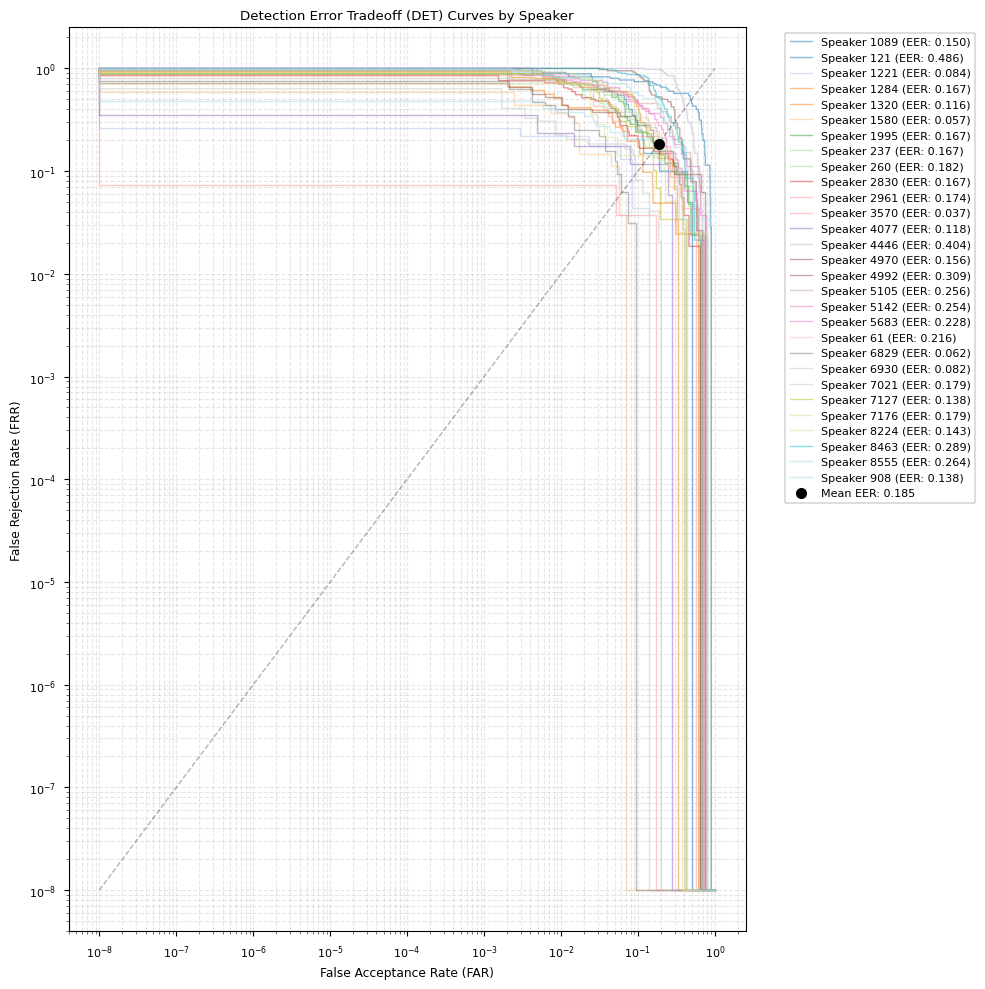

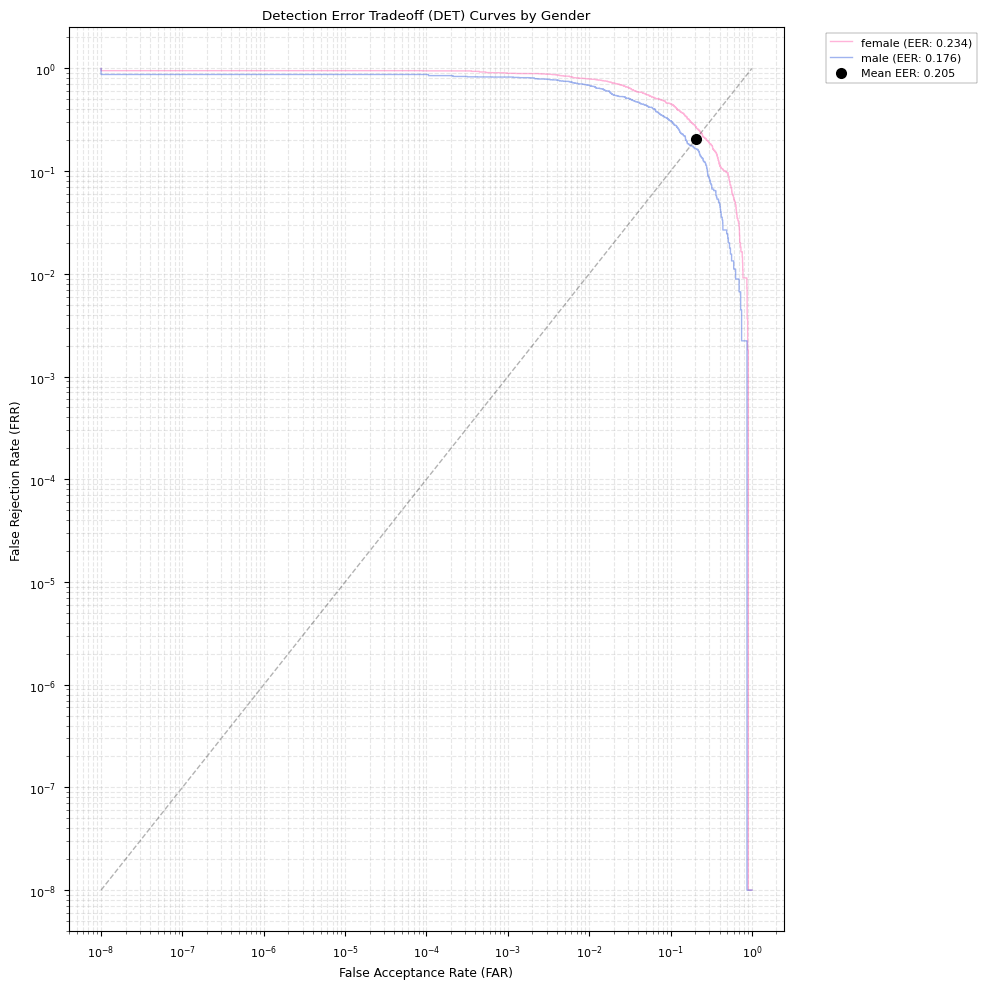

In [13]:
fig_speaker, speaker_metrics, speaker_eer = analyze_speaker_results(
    df, output_path=f'results/speaker_DET_{anon_model}.png', max_speakers=None)
fig_gender, gender_metrics, gender_eer = analyze_gender_results(
    df, output_path=f'results/gender_DET_{anon_model}.png')

# Save results as csvs
speaker_metrics_df = pd.DataFrame.from_records(speaker_metrics).astype(float)
gender_metrics_df = pd.DataFrame.from_records(gender_metrics).astype(float)
speaker_metrics_df.to_csv(f'results/per_speaker_results_{anon_model}.csv')
gender_metrics_df.to_csv(f'results/per_gender_results_{anon_model}.csv')

# Create radar plot
create_radar_plot(speaker_eer, output_path=f'results/speaker_eer_{anon_model}.png')